# Communities

In [8]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [9]:
import matplotlib.pyplot as plt
import logging
import numpy as np
from optparse import OptionParser
import sys
from time import time

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import RidgeClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB, ComplementNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.extmath import density
from sklearn import metrics

## Create User Summaries for Labeled Community Data + TF-IDF Model

#### 1.) Load df with processed text and descriptions

In [3]:
import pandas as pd

df = pd.read_csv('data/million_df.csv', index_col=0)
#fill NaN text fields with blank text
df['text'].fillna(' ', inplace=True)
df['user_description'].fillna(' ', inplace=True)
#df['hashtags'].fillna('', inplace=True)
df['user_location'].fillna(' ', inplace=True)
#make sure all rows are str type
df['text'] = df['text'].astype('str')
df['user_description'] = df['user_description'].astype('str')
#df['hashtags'] = df['hashtags'].astype('str')
df['user_location'] = df['user_location'].astype('str')
df['user_screen_name'] = df['user_screen_name'].astype('str')
# nodes = 
# edges = 
# tweets = 605,000
# total users =
df.columns

Index(['coordinates', 'created_at', 'hashtags', 'media', 'urls',
       'favorite_count', 'id', 'in_reply_to_screen_name',
       'in_reply_to_status_id', 'in_reply_to_user_id', 'lang', 'place',
       'possibly_sensitive', 'retweet_count', 'reweet_id',
       'retweet_screen_name', 'source', 'text', 'tweet_url', 'user_created_at',
       'user_screen_name', 'user_default_profile_image', 'user_description',
       'user_favourites_count', 'user_followers_count', 'user_friends_count',
       'user_listed_count', 'user_location', 'user_name', 'user_screen_name.1',
       'user_statuses_count', 'user_time_zone', 'user_urls', 'user_verified'],
      dtype='object')

#### 2.) Load labeled community df

In [4]:
#open labeled community nodes
community_df = pd.read_csv('data/million_nodes.csv', index_col='Id')
#take only the basic features for now
community_df[['Label','modularity_class']]

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (0,1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Label,modularity_class
Id,,
7874982,lauraleishman,0
18464266,peterdaou,13
25493304,zachhaller,2
539666970,NewsNeck,8
106182754,Richard_Schiff,13
...,...,...
241010173,NaN,2
159538373,NaN,13
236966874,NaN,68


#### 3.) Merge community labels onto tweet df

In [5]:
labeled_df = df.merge(community_df, left_on='user_screen_name', right_on='Label', how='outer')
# how many labeled tweets do we have? ~495,000
labeled_df['modularity_class'].dropna()

1             1.0
3            13.0
4            13.0
5            13.0
6            13.0
           ...   
930911      613.0
930912    11203.0
930913       13.0
930914       12.0
930915       30.0
Name: modularity_class, Length: 495026, dtype: float64

In [6]:
#filter out all those rows that don't have an assigned modularity class. Keep unlabeled ones for later use.
unlabeled_df = labeled_df[labeled_df['modularity_class'].isna() == True]
labeled_df = labeled_df[labeled_df['modularity_class'].isna() == False]

In [7]:
#drop the unneeded columns
features = [
        'id', 'user_location',
       'favorite_count', 
        'retweet_count', 
       'text', 
       'user_screen_name', 'user_description',
       'user_followers_count', 
       'user_name', 
       'modularity_class']
labeled_df = labeled_df[features]
#rename community column
labeled_df.rename(columns={'modularity_class':'community'},inplace=True)

In [8]:
#drop the users with no username
labeled_df = labeled_df[labeled_df['user_screen_name'].isna() == False]
labeled_df['user_screen_name'] = labeled_df['user_screen_name'].astype('str')

In [9]:
# group by username and combine their tweet text, hashtags
combined_text = labeled_df.groupby('user_screen_name').apply(lambda x: ' '.join(x['text']))
combined_text.rename('combined_text', inplace=True)

labeled_df = labeled_df.merge(combined_text, left_on='user_screen_name', right_index=True)

user_summary = labeled_df.groupby(['user_screen_name', 'user_location','user_description', 'combined_text', 'community']).mean()
user_summary.drop(columns=['id'], inplace=True)
user_summary.reset_index(inplace=True)

user_screen_name
000bangbang000                                                      
00LovelyDay00      unity probably stop saying name   chanting `` ...
01507db5dba34b2                                                  htt
01_zebra                                     next scum complete scum
0463diamond        `` theme tonight 'compassion criminals '' woma...
                                         ...                        
zunigasalvador     walk water heal sick went roman b really horny...
zuriberry          jordan davis mother stop mother child dies mot...
zzelda01           https media plays bernie drama pro-hillary cli...
zzyzxbaker         sheeple march near extreme heat chant extreme ...
zzzanthropology    need step needs step prison jumpsuit needs sto...
Name: combined_text, Length: 31241, dtype: object

#### 4.) Break top 17 communities into separate df and explore data

In [10]:
# select the users that belong to one of the largest 17 communities. Smallest community = 1% of all users. 
top_communities = [30.0, 13.0, 2.0, 6.0, 8.0, 61.0, 58.0, 68.0, 127.0, 12.0, 70.0, 1029.0, 62.0, 50.0, 273.0, 4382.0, 32.0]

#user_summary = user_summary[user_summary['community'] in top_communities]
user_summary = user_summary[user_summary['community'].apply(lambda x: x in top_communities)]
user_summary

#for label in top_communities:
#    users = user_summary[user_summary['community'] == label].copy()
#    print('Community Label = {}'.format(label))
#    plot_wordcloud((' '.join(users['combined_text'])), save=False, stop_words=['demconvention', 'democratic', 'debate', 'dncinphl', 'convention', 'tonight', 'vote'])
top_communities.sort()
for label in top_communities:
    print('{}:'.format(label), (user_summary[user_summary['community'] == float(label)].shape[0] / user_summary.shape[0])*100, '%')

#for label in top_communities:
#    users = user_summary[user_summary['community'] == label].copy()
#    plot_wordcloud((' '.join(users['user_description'])), save=False, stop_words=['demconvention', 'democratic', 'debate', 'dncinphl', 'convention', 'tonight', 'vote'])
user_summary.to_csv('data/community_labeled_users.csv')

,user_screen_name,user_location,user_description,combined_text,community,favorite_count,retweet_count,user_followers_count
0,000bangbang000,,ecclesiastes :8 ++there time war time peace++ ...,,2.0,2.000000,2.000000,4.0
1,00LovelyDay00,face usa,speak sarcasm truth people dont criminals 'm p...,unity probably stop saying name chanting `` ...,30.0,0.333333,180.333333,3917.0
3,01_zebra,usa,banner maga zebra christian animal doc selah m...,next scum complete scum,30.0,0.000000,0.000000,13395.0
4,0463diamond,,,`` theme tonight 'compassion criminals '' woma...,30.0,0.000000,269.272727,333.0
5,0516_864,hilton head island sc,life short argue constitutional birthrights,'ve saying neither sent nore received classifi...,30.0,1.000000,0.000000,2646.0
...,...,...,...,...,...,...,...,...
31251,zunigasalvador,princeton nj,producer jersey,walk water heal sick went roman b really horny...,2.0,0.000000,0.000000,331.0
31252,zuriberry,washington dc,senior managing editor send tips zberry wamu d...,jordan davis mother stop mother child dies mot...,61.0,0.625000,1.250000,5939.0
31253,zzelda01,red hell,strong educated old woman activist child anti-...,https media plays bernie drama pro-hillary cli...,13.0,0.333333,9.666667,8555.0
31254,zzyzxbaker,united states,constitution loving conservative natural born ...,sheeple march near extreme heat chant extreme ...,30.0,0.000000,274.800000,2478.7


2.0: 16.22114909312141 %
6.0: 4.1142248754705495 %
8.0: 3.6008973725236704 %
12.0: 2.091334271265067 %
13.0: 28.45355336704818 %
30.0: 23.126354614243887 %
32.0: 1.5171679531541125 %
50.0: 1.760523213810411 %
58.0: 4.197878246321153 %
61.0: 3.7339822806950833 %
62.0: 1.1407277843264003 %
68.0: 3.406973649188182 %
70.0: 1.2624054146545496 %
127.0: 2.262443438914027 %
273.0: 2.3270846800258567 %
1029.0: 0.19012129738773337 %
4382.0: 0.5931784478497282 %


In [4]:
import pandas as pd
user_summary = pd.read_csv('data/community_labeled_users.csv')
user_summary

,Unnamed: 0,user_screen_name,user_location,user_description,combined_text,community,favorite_count,retweet_count,user_followers_count
0,0,000bangbang000,,ecclesiastes :8 ++there time war time peace++ ...,,2.0,2.000000,2.000000,4.0
1,1,00LovelyDay00,face usa,speak sarcasm truth people dont criminals 'm p...,unity probably stop saying name chanting `` ...,30.0,0.333333,180.333333,3917.0
2,3,01_zebra,usa,banner maga zebra christian animal doc selah m...,next scum complete scum,30.0,0.000000,0.000000,13395.0
3,4,0463diamond,,,`` theme tonight 'compassion criminals '' woma...,30.0,0.000000,269.272727,333.0
4,5,0516_864,hilton head island sc,life short argue constitutional birthrights,'ve saying neither sent nore received classifi...,30.0,1.000000,0.000000,2646.0
...,...,...,...,...,...,...,...,...,...
26294,31251,zunigasalvador,princeton nj,producer jersey,walk water heal sick went roman b really horny...,2.0,0.000000,0.000000,331.0
26295,31252,zuriberry,washington dc,senior managing editor send tips zberry wamu d...,jordan davis mother stop mother child dies mot...,61.0,0.625000,1.250000,5939.0
26296,31253,zzelda01,red hell,strong educated old woman activist child anti-...,https media plays bernie drama pro-hillary cli...,13.0,0.333333,9.666667,8555.0
26297,31254,zzyzxbaker,united states,constitution loving conservative natural born ...,sheeple march near extreme heat chant extreme ...,30.0,0.000000,274.800000,2478.7


#### 5.) Vectorize / TFIDF

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB, ComplementNB, MultinomialNB
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

vectorizer = TfidfVectorizer()


X = user_summary['user_description'] + ' ' + user_summary['user_location'] + ' ' +  user_summary['combined_text']
y = user_summary['community']

X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y)

X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [6]:
X_train.size
X_train.shape

(19724, 46254)

In [10]:
# Plot top tf-idf features
# Author: Peter Prettenhofer <peter.prettenhofer@gmail.com>
#         Olivier Grisel <olivier.grisel@ensta.org>
#         Mathieu Blondel <mathieu@mblondel.org>
#         Lars Buitinck
# License: BSD 3 clause

def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

def top_feats_in_doc(Xtr, features, row_id, top_n=25):
    row = np.squeeze(Xtr[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)

feature_names=vectorizer.get_feature_names()
top_feats_in_doc(X_train,feature_names,1)

,feature,tfidf
0,rise,0.223624
1,sugarhood,0.211743
2,whiney,0.211743
3,democrative,0.211743
4,trod,0.203323
5,mpp,0.197349
6,coherent,0.192715
7,slc,0.188929
8,surprisingly,0.185728
9,shallow,0.182955


In [11]:
feature_names[0:10]

['00',
 '000',
 '00002',
 '001',
 '00146',
 '0048',
 '005313',
 '00am',
 '00ish',
 '00pm']

In [12]:
def top_mean_feats(Xtr, features, grp_ids=None, min_tfidf=0.1, top_n=25):
    ''' Return the top n features that on average are most important amongst documents in rows
        indentified by indices in grp_ids. '''
    if grp_ids:
        D = Xtr[grp_ids].toarray()
    else:
        D = Xtr.toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)

def top_feats_by_class(Xtr, y, features, min_tfidf=0.1, top_n=25):
    ''' Return a list of dfs, where each df holds top_n features and their mean tfidf value
        calculated across documents with the same class label. '''
    dfs = []
    labels = np.unique(y)
    for label in labels:
        ids = np.where(y==label)
        feats_df = top_mean_feats(Xtr, features, ids, min_tfidf=min_tfidf, top_n=top_n)
        feats_df.label = label
        dfs.append(feats_df)
    return dfs
dfs=top_feats_by_class(X_train,y_train,feature_names, top_n=25)

In [13]:
len(dfs)

17

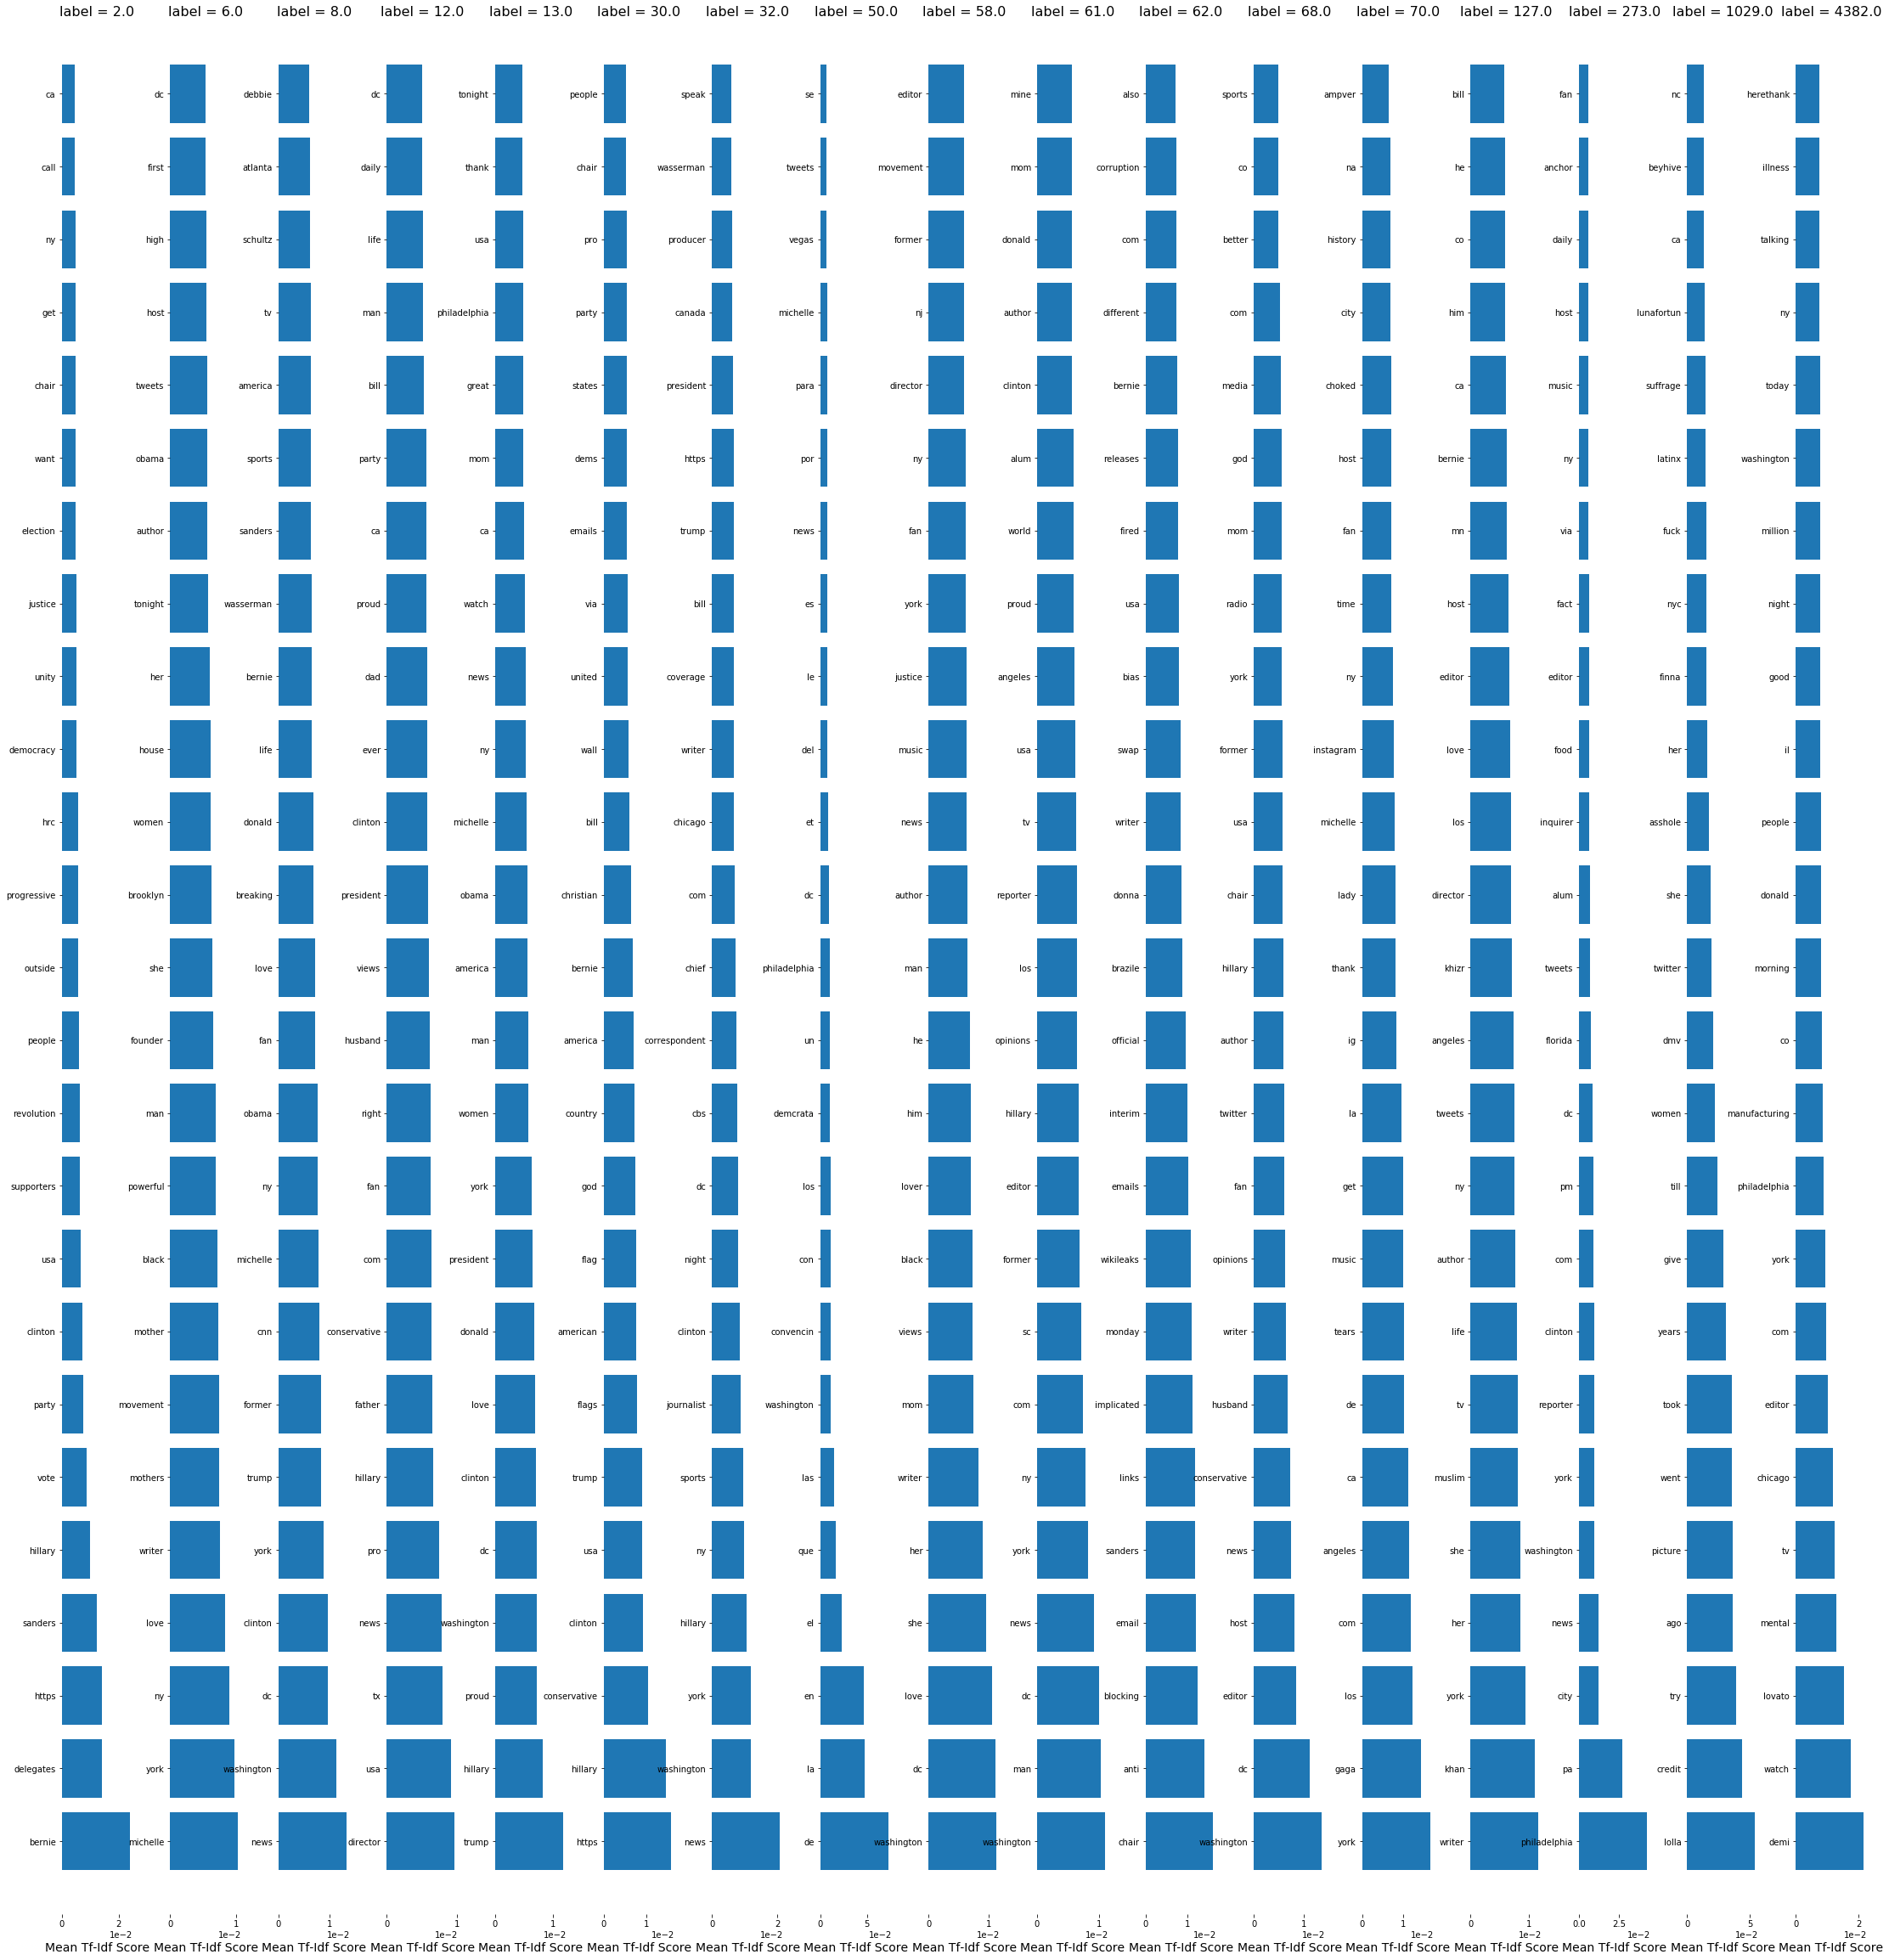

<Figure size 432x288 with 0 Axes>

In [14]:
def plot_tfidf_classfeats_h(dfs):
    ''' Plot the data frames returned by the function plot_tfidf_classfeats(). '''
    fig = plt.figure(figsize=(36, 36), facecolor="w",)
    x = np.arange(len(dfs[0]))
    for i, df in enumerate(dfs):
        ax = fig.add_subplot(1, len(dfs), i+1)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_frame_on(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.set_xlabel("Mean Tf-Idf Score", labelpad=16, fontsize=14)
        ax.set_title("label = " + str(df.label), fontsize=16)
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
        ax.barh(x, df.tfidf, align='center')
        ax.set_yticks(x)
        ax.set_ylim([-1, x[-1]+1])
        yticks = ax.set_yticklabels(df.feature)
        plt.subplots_adjust(bottom=0.09, right=0.97, left=0.15, top=0.95, wspace=0.52)
    #plt.set_cmap('viridis')    
    plt.show()
    plt.savefig('data/17_class_tfidf.png', dpi=240)

plot_tfidf_classfeats_h(dfs)

In [15]:
user_summary[user_summary['community'] == 4382.0]

,Unnamed: 0,user_screen_name,user_location,user_description,combined_text,community,favorite_count,retweet_count,user_followers_count
219,251,58thPresidency,paulo brasil,poltica e eleies americanas visite site,muitos delegados tm nas mos cartazes anti-tpp ...,4382.0,0.000000,0.000000,442.000000
299,347,ABC6,providence rhode island,abc6 provides news coverage connects southern ...,special report pm speaking tonight committee c...,4382.0,0.750000,12.000000,23790.250000
335,388,AERdiplo_5,,fall '11 photographer writer leader venezolano...,took picture years ago went lolla try give cre...,4382.0,0.000000,2140.800000,782.000000
564,663,AgingAbundantly,north carolina,author writer seeker philosopher founder,cynical dismissive easy hard optimistic enough...,4382.0,0.000000,122.000000,13316.000000
635,752,AlexHolleyFOX29,philadelphia,emmy-nominated co-host good 'm follow u might ...,noticed using patriotic cars,4382.0,26.000000,9.000000,66376.000000
...,...,...,...,...,...,...,...,...,...
25684,30512,usatodaylife,usa today hq mclean va,latest entertainment celebrity news along movi...,mental health 'we better million million equiv...,4382.0,0.000000,1.500000,82609.000000
25701,30532,uzmanauman,lahore,working anchor gnn alumni august `` .tweets pe...,thank describing experience dealing mental ill...,4382.0,0.000000,6478.000000,76325.000000
25813,30671,voaindonesia,washington dc,voice america adalah jaringan siaran radio tel...,saksikan laporan langsung bersama tentang konv...,4382.0,2.200000,2.400000,310465.600000
26056,30974,wogl,philadelphia,nobody plays listen app,wan na know survive week check guide additiona...,4382.0,0.714286,0.571429,3492.285714


# Benchmark Models

In [16]:
target_names = y.unique().astype('str')
target_names

array(['2.0', '30.0', '127.0', '58.0', '13.0', '6.0', '61.0', '70.0',
       '8.0', '273.0', '50.0', '12.0', '68.0', '62.0', '4382.0', '32.0',
       '1029.0'], dtype='<U32')

In [17]:
# Author: Peter Prettenhofer <peter.prettenhofer@gmail.com>
#         Olivier Grisel <olivier.grisel@ensta.org>
#         Mathieu Blondel <mathieu@mblondel.org>
#         Lars Buitinck
# License: BSD 3 clause


def benchmark(clf):
    print('_' * 80)
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(X_train, y_train)
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time()
    pred = clf.predict(X_test)
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)

    score = metrics.accuracy_score(y_test, pred)
    print("accuracy:   %0.3f" % score)

    if hasattr(clf, 'coef_'):
        print("dimensionality: %d" % clf.coef_.shape[1])
        print("density: %f" % density(clf.coef_))


        print("classification report:")
        print(metrics.classification_report(y_test, pred,
                                            target_names=target_names))

    print("confusion matrix:")
    print(metrics.confusion_matrix(y_test, pred))

    print()
    clf_descr = str(clf).split('(')[0]
    return clf_descr, score, train_time, test_time


results = []
for clf, name in (
        (RidgeClassifier(tol=1e-2, solver="auto"), "Ridge Classifier"),
        #(Perceptron(max_iter=50), "Perceptron"),
        #(PassiveAggressiveClassifier(max_iter=50),
         #"Passive-Aggressive"),
        (KNeighborsClassifier(n_neighbors=10), "kNN"),
        (RandomForestClassifier(), "Random forest")):
    print('=' * 80)
    print(name)
    results.append(benchmark(clf))

for penalty in ["l2"]:#, "l1"]:
    print('=' * 80)
    print("%s penalty" % penalty.upper())
    # Train Liblinear model
    #results.append(benchmark(LinearSVC(penalty=penalty, dual=False,
    #                                   tol=1e-3)))

    # Train SGD model
    results.append(benchmark(SGDClassifier(alpha=.0001, max_iter=50,
                                           penalty=penalty)))

# Train SGD with Elastic Net penalty
print('=' * 80)
print("Elastic-Net penalty")
results.append(benchmark(SGDClassifier(alpha=.0001, max_iter=50,
                                       penalty="elasticnet")))

# Train NearestCentroid without threshold
print('=' * 80)
print("NearestCentroid (aka Rocchio classifier)")
results.append(benchmark(NearestCentroid()))

# Train sparse Naive Bayes classifiers
print('=' * 80)
print("Naive Bayes")
results.append(benchmark(MultinomialNB(alpha=.01)))
#results.append(benchmark(BernoulliNB(alpha=.01)))
#results.append(benchmark(ComplementNB(alpha=.1)))

print('=' * 80)
print("LinearSVC with L1-based feature selection")
# The smaller C, the stronger the regularization.
# The more regularization, the more sparsity.
#results.append(benchmark(Pipeline([
#  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False,
#                                                  tol=1e-3))),
#  ('classification', LinearSVC(penalty="l2"))])))

Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, normalize=False, random_state=None,
                solver='auto', tol=0.01)
train time: 1.131s
test time:  0.006s
accuracy:   0.522
dimensionality: 46254
density: 1.000000
classification report:
              precision    recall  f1-score   support

         2.0       0.53      0.58      0.56      1067
        30.0       0.30      0.08      0.12       270
       127.0       0.20      0.04      0.06       237
        58.0       0.12      0.01      0.01       137
        13.0       0.48      0.78      0.59      1871
         6.0       0.63      0.79      0.70      1521
        61.0       0.38      0.03      0.06       100
        70.0       0.47      0.30      0.37       116
         8.0       0.20      0.04      0.06       276
       273.0       0.29      0.07      0.11 

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [18]:
results

[('RidgeClassifier',
  0.5218250950570342,
  1.1310009956359863,
  0.0064470767974853516),
 ('KNeighborsClassifier',
  0.19193916349809886,
  0.005051374435424805,
  6.65585470199585),
 ('RandomForestClassifier',
  0.4967300380228137,
  69.67411732673645,
  0.7311768531799316),
 ('SGDClassifier',
  0.5183269961977186,
  0.8094277381896973,
  0.010754108428955078),
 ('SGDClassifier',
  0.5067680608365019,
  2.129842519760132,
  0.011065483093261719),
 ('NearestCentroid',
  0.36714828897338403,
  0.028228282928466797,
  0.011790990829467773),
 ('MultinomialNB',
  0.526083650190114,
  0.05896115303039551,
  0.009055852890014648)]

In [29]:
results = [('Random', 0.0588, 0.0, 0.0),
            ('KNeighborsClassifier',
             0.19193916349809886,
             0.005051374435424805,
             6.65585470199585),
            ('NearestCentroid',
             0.36714828897338403,
             0.028228282928466797,
             0.011790990829467773),
            ('RandomForestClassifier',
             0.4967300380228137,
             69.67411732673645,
             0.7311768531799316),
            ('SGDClassifier',
             0.5183269961977186,
             0.8094277381896973,
             0.010754108428955078),
            ('RidgeClassifier',
             0.5218250950570342,
             1.1310009956359863,
             0.0064470767974853516),
            ('MultinomialNB',
             0.526083650190114,
             0.05896115303039551,
             0.009055852890014648)
            ]
results

[('Random', 0.0588, 0.0, 0.0),
 ('KNeighborsClassifier',
  0.19193916349809886,
  0.005051374435424805,
  6.65585470199585),
 ('NearestCentroid',
  0.36714828897338403,
  0.028228282928466797,
  0.011790990829467773),
 ('RandomForestClassifier',
  0.4967300380228137,
  69.67411732673645,
  0.7311768531799316),
 ('SGDClassifier',
  0.5183269961977186,
  0.8094277381896973,
  0.010754108428955078),
 ('RidgeClassifier',
  0.5218250950570342,
  1.1310009956359863,
  0.0064470767974853516),
 ('MultinomialNB',
  0.526083650190114,
  0.05896115303039551,
  0.009055852890014648)]

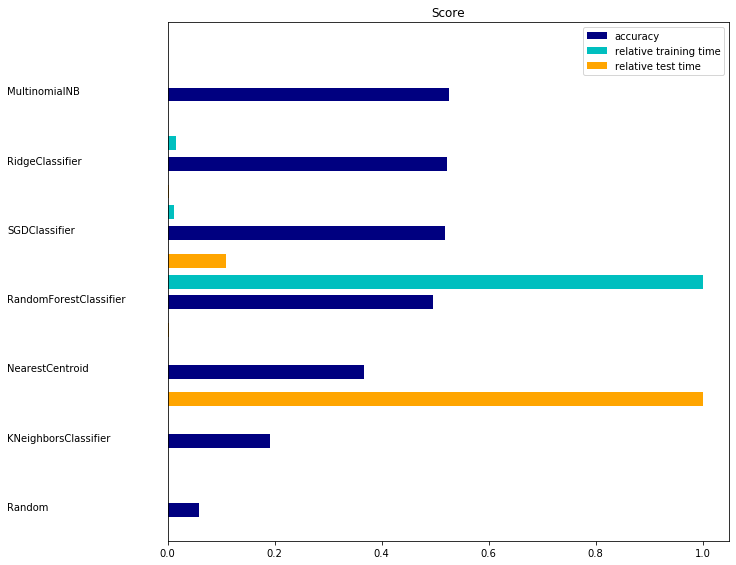

In [30]:
indices = np.arange(len(results))

results = [[x[i] for x in results] for i in range(4)]

clf_names, score, training_time, test_time = results
training_time = np.array(training_time) / np.max(training_time)
test_time = np.array(test_time) / np.max(test_time)

plt.figure(figsize=(12, 8))
plt.title("Score")
plt.barh(indices, score, .2, label="accuracy", color='navy')
plt.barh(indices + .3, training_time, .2, label="relative training time",
         color='c')
plt.barh(indices + .6, test_time, .2, label="relative test time", color='orange')
plt.yticks(())
plt.legend(loc='best')
plt.subplots_adjust(left=.25)
plt.subplots_adjust(top=.95)
plt.subplots_adjust(bottom=.05)

for i, c in zip(indices, clf_names):
    plt.text(-.3, i, c)

plt.show()

# Repeat TF-IDF but Limit to 10 Largest Communities

In [1]:
import pandas as pd
import numpy as np
user_summary = pd.read_csv('data/community_labeled_users.csv', index_col=0)

In [2]:
# select the users that belong to one of the largest 17 communities. Smallest community = 1% of all users. 
top10_communities = [30.0, 13.0, 2.0, 6.0, 8.0, 61.0, 58.0, 68.0, 127.0, 12.0]

#user_summary = user_summary[user_summary['community'] in top_communities]
user_summary = user_summary[user_summary['community'].apply(lambda x: x in top10_communities)]
user_summary

#for label in top_communities:
#    users = user_summary[user_summary['community'] == label].copy()
#    print('Community Label = {}'.format(label))
#    plot_wordcloud((' '.join(users['combined_text'])), save=False, stop_words=['demconvention', 'democratic', 'debate', 'dncinphl', 'convention', 'tonight', 'vote'])
top10_communities.sort()
for label in top10_communities:
    print('{}:'.format(label), (user_summary[user_summary['community'] == float(label)].shape[0] / user_summary.shape[0])*100, '%')

#for label in top_communities:
#    users = user_summary[user_summary['community'] == label].copy()
#    plot_wordcloud((' '.join(users['user_description'])), save=False, stop_words=['demconvention', 'democratic', 'debate', 'dncinphl', 'convention', 'tonight', 'vote'])
user_summary.to_csv('data/top10_community_labeled_users.csv')

2.0: 17.784633343060825 %
6.0: 4.510776670696627 %
8.0: 3.9479718180681203 %
12.0: 2.2929086588568808 %
13.0: 31.196064534956434 %
30.0: 25.355400842122815 %
58.0: 4.602493017050903 %
61.0: 4.093884187268103 %
68.0: 3.7353566515195733 %
127.0: 2.4805102763997167 %


In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB, ComplementNB, MultinomialNB
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

vectorizer = TfidfVectorizer()


X = user_summary['user_description'] + user_summary['user_location'] + user_summary['combined_text']
y = user_summary['community']

X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y)

X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [4]:
vectorizer.get_params

<bound method BaseEstimator.get_params of TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)>

In [5]:
# Plot top tf-idf features
# Author: Peter Prettenhofer <peter.prettenhofer@gmail.com>
#         Olivier Grisel <olivier.grisel@ensta.org>
#         Mathieu Blondel <mathieu@mblondel.org>
#         Lars Buitinck
# License: BSD 3 clause

def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

def top_feats_in_doc(Xtr, features, row_id, top_n=25):
    row = np.squeeze(Xtr[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)

feature_names=vectorizer.get_feature_names()
top_feats_in_doc(X_train,feature_names,1)

,feature,tfidf
0,stirring,0.487723
1,plot,0.471151
2,trolls,0.403566
3,racial,0.403028
4,blocked,0.359465
5,wow,0.292628
6,zzzzzzzzzzzzzz,0.000000
7,fest,0.000000
8,festivities,0.000000
9,festivemoney,0.000000


In [6]:
def top_mean_feats(Xtr, features, grp_ids=None, min_tfidf=0.1, top_n=25):
    ''' Return the top n features that on average are most important amongst documents in rows
        indentified by indices in grp_ids. '''
    if grp_ids:
        D = Xtr[grp_ids].toarray()
    else:
        D = Xtr.toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)

def top_feats_by_class(Xtr, y, features, min_tfidf=0.1, top_n=25):
    ''' Return a list of dfs, where each df holds top_n features and their mean tfidf value
        calculated across documents with the same class label. '''
    dfs = []
    labels = np.unique(y)
    for label in labels:
        ids = np.where(y==label)
        feats_df = top_mean_feats(Xtr, features, ids, min_tfidf=min_tfidf, top_n=top_n)
        feats_df.label = label
        dfs.append(feats_df)
    return dfs
dfs=top_feats_by_class(X_train,y_train,feature_names, top_n=25)

In [7]:
len(dfs)

10

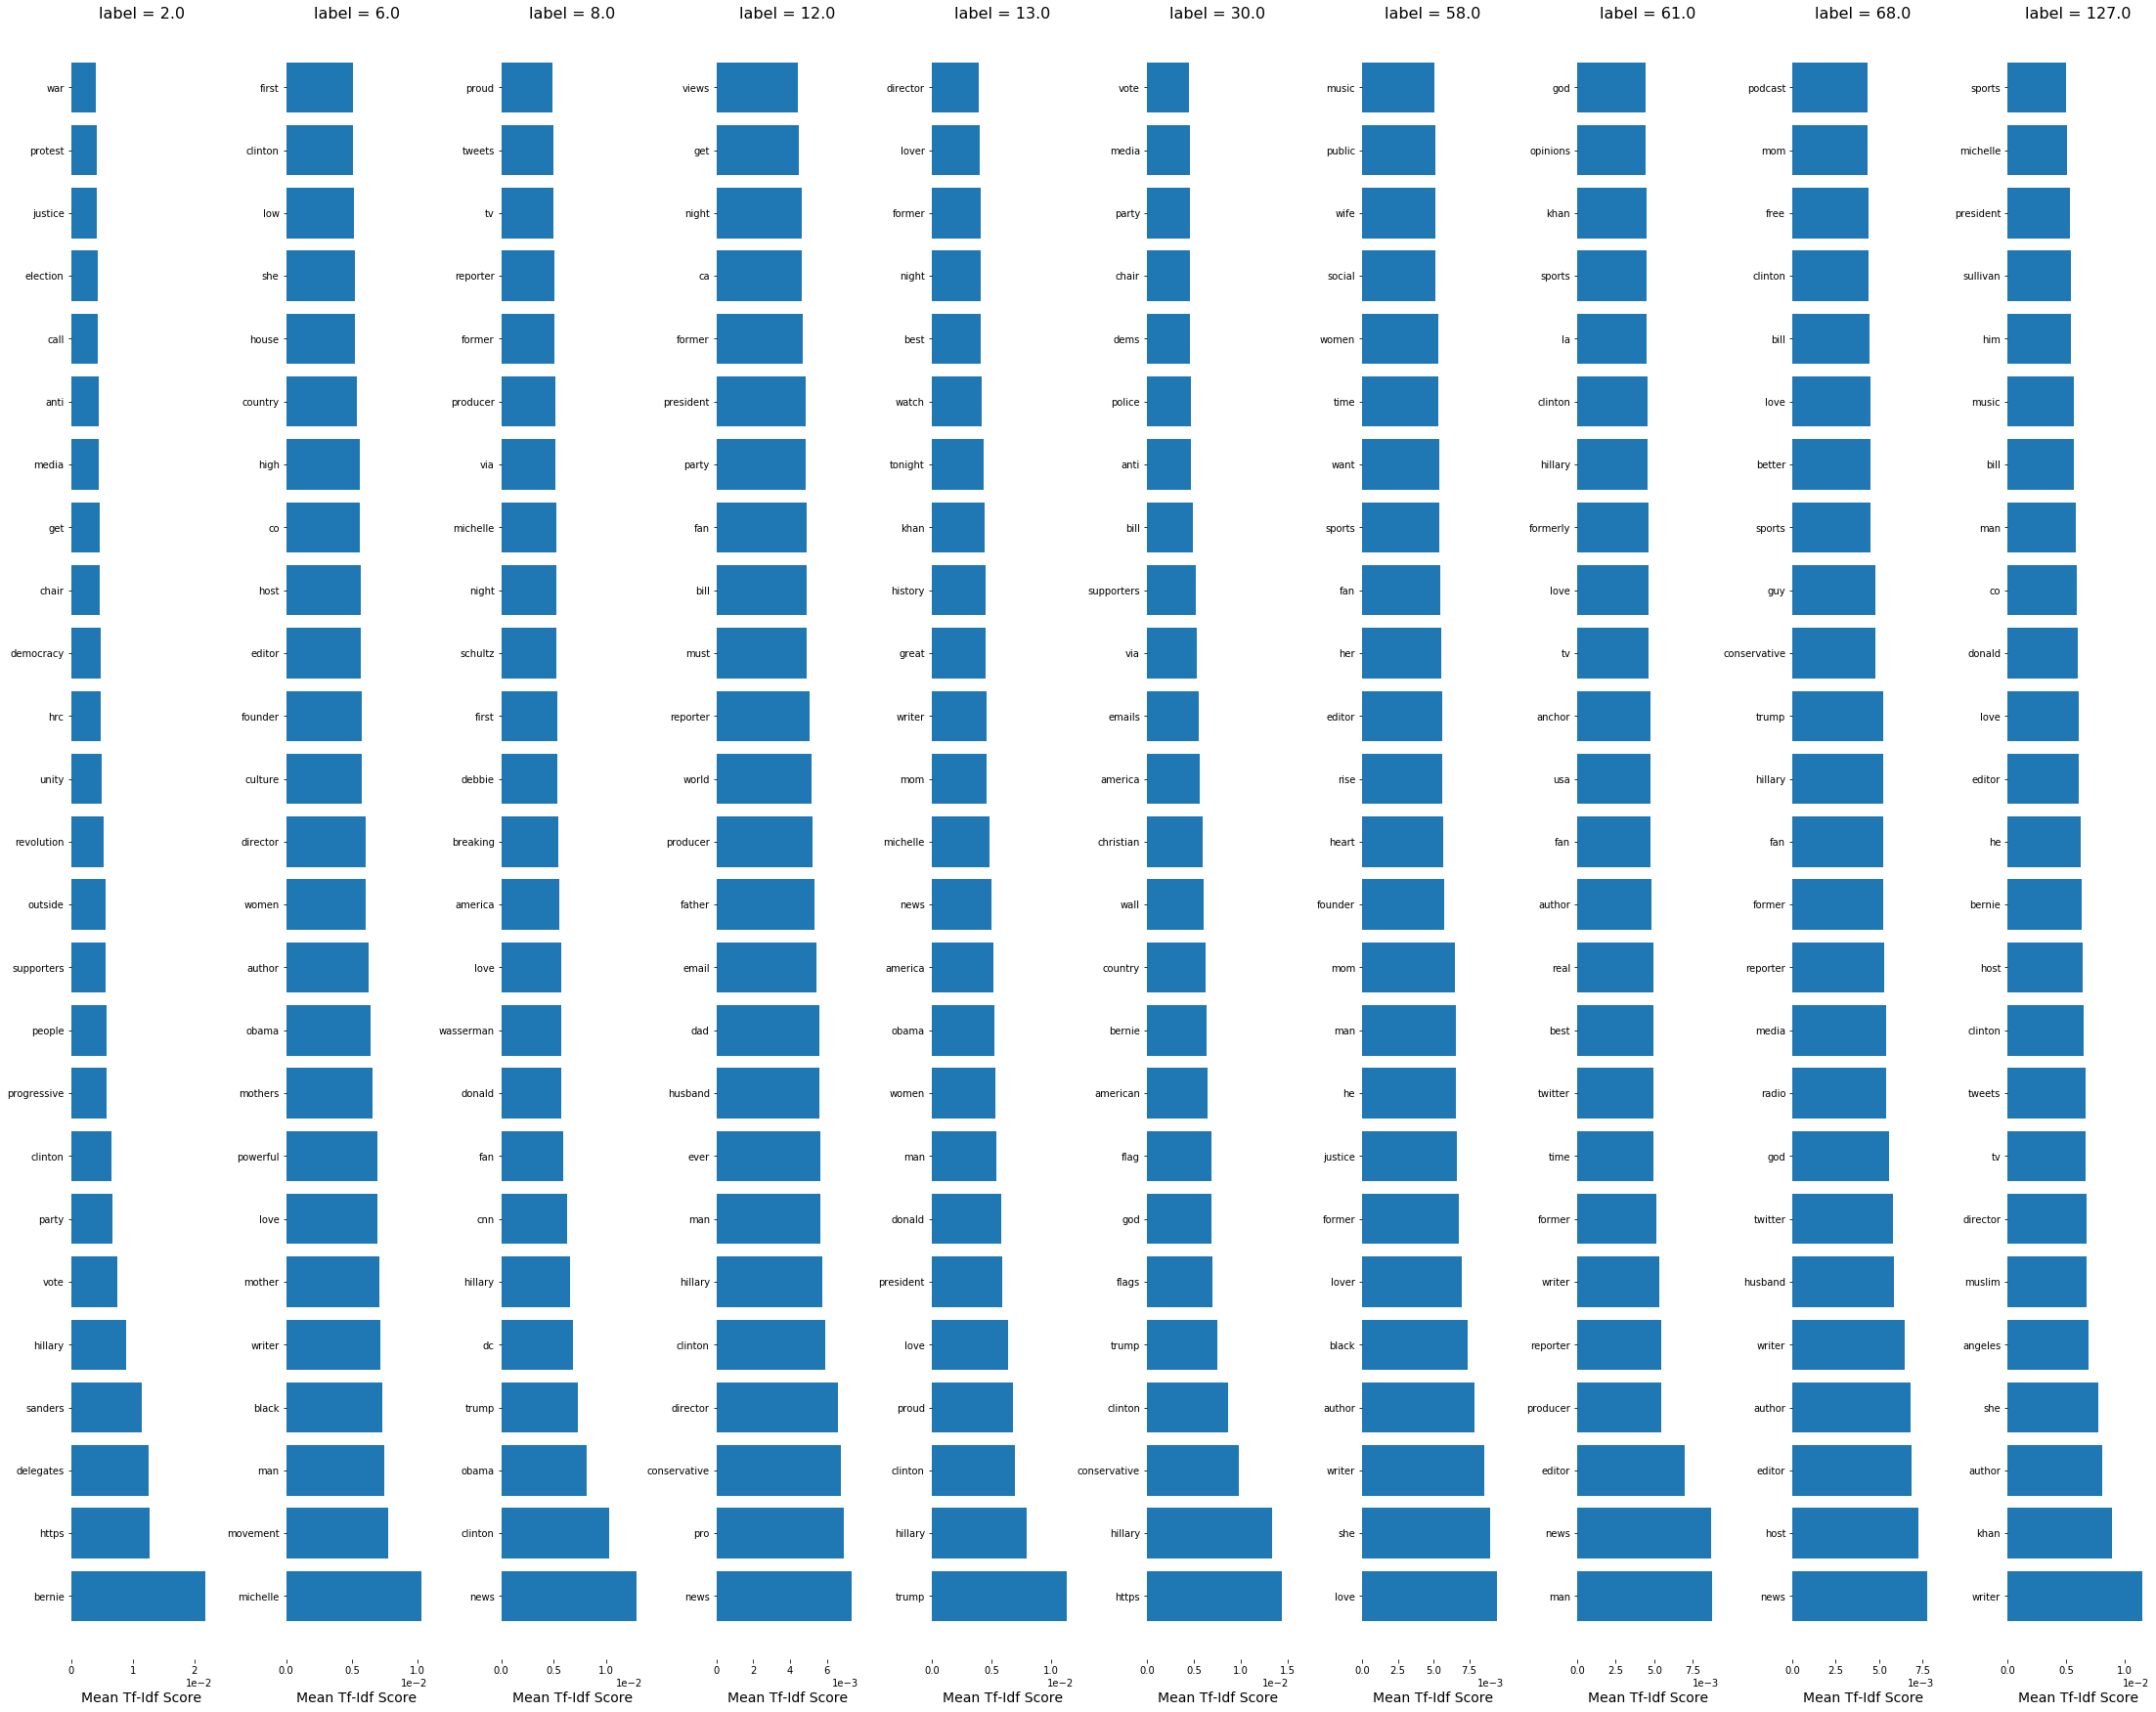

<Figure size 432x288 with 0 Axes>

In [10]:
def plot_tfidf_classfeats_h(dfs):
    ''' Plot the data frames returned by the function plot_tfidf_classfeats(). '''
    fig = plt.figure(figsize=(36, 27), facecolor="w",)
    x = np.arange(len(dfs[0]))
    for i, df in enumerate(dfs):
        ax = fig.add_subplot(1, len(dfs), i+1)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_frame_on(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.set_xlabel("Mean Tf-Idf Score", labelpad=16, fontsize=14)
        ax.set_title("label = " + str(df.label), fontsize=16)
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
        ax.barh(x, df.tfidf, align='center')
        ax.set_yticks(x)
        ax.set_ylim([-1, x[-1]+1])
        yticks = ax.set_yticklabels(df.feature)
        plt.subplots_adjust(bottom=0.09, right=0.97, left=0.15, top=0.95, wspace=0.52)
    plt.set_cmap('viridis')    
    plt.show()
    plt.set_cmap('viridis')

plot_tfidf_classfeats_h(dfs)
plt.savefig('data/17_class_tfidf.png', dpi=240)

In [18]:
top10_communities

[2.0, 6.0, 8.0, 12.0, 13.0, 30.0, 58.0, 61.0, 68.0, 127.0]

In [ ]:
30.0  Conservatives who value God, flag, country, and wall
13.0  Husbands and fathers who work in conservative media.
2.0   Progressives, Bernie Sanders supporters. 
6.0   Black women, mothers and fans of Michelle Obama
8.0   Journalists talking about the DNC chair debbie wazzerman shultz
61.0 
12.0 
58.0  Wives, moms, positivity
68.0  Religious conservative men
127.0

In [ ]:
# labels
label_0 = bernie delegates, progressives who are talk about a politicla revolution. Anti-war, justice and unity
label_1 = Women, Mothers, Black, talk about michelle obama
label_2 = Mainstreams anchors hournalists hosts, mostly at CNN
label_3 = guys, fathers, dads, professionals in news media who are conservatives and talk about hillary
label_4 = mothers moms 
label_5 = religious conservatives
label_6 = journalists talking about the DNC chair debbie wazzerman shultz
label_7 = Hispanic and Latinx Persons
label_8 = authors and writers
label_9 = news people
label_10 = conservatives talking about donna brazille and implicating corruption, talking about wikileaks
label_11 = Religious males (husbands) who work in media (radio
label_12 = 
label_13 = Muslim Persons 
label_14 = Reporterrs
label_15 = latina, teenages, 'don't give a ****'
label_16 = talking about mental illness and demi lovato (?)

# Benchmark Models

In [11]:
target_names = y.unique().astype('str')
target_names

array(['2.0', '30.0', '127.0', '58.0', '13.0', '6.0', '61.0', '8.0',
       '12.0', '68.0'], dtype='<U32')

In [12]:
# Author: Peter Prettenhofer <peter.prettenhofer@gmail.com>
#         Olivier Grisel <olivier.grisel@ensta.org>
#         Mathieu Blondel <mathieu@mblondel.org>
#         Lars Buitinck
# License: BSD 3 clause


def benchmark(clf):
    print('_' * 80)
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(X_train, y_train)
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time()
    pred = clf.predict(X_test)
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)

    score = metrics.accuracy_score(y_test, pred)
    print("accuracy:   %0.3f" % score)

    if hasattr(clf, 'coef_'):
        print("dimensionality: %d" % clf.coef_.shape[1])
        print("density: %f" % density(clf.coef_))


        print("classification report:")
        print(metrics.classification_report(y_test, pred,
                                            target_names=target_names))

    print("confusion matrix:")
    print(metrics.confusion_matrix(y_test, pred))

    print()
    clf_descr = str(clf).split('(')[0]
    return clf_descr, score, train_time, test_time


results = []
for clf, name in (
        (RidgeClassifier(tol=1e-2, solver="auto"), "Ridge Classifier"),
        #(Perceptron(max_iter=50), "Perceptron"),
        #(PassiveAggressiveClassifier(max_iter=50),
         #"Passive-Aggressive"),
        (KNeighborsClassifier(n_neighbors=10), "kNN"),
        (RandomForestClassifier(), "Random forest")):
    print('=' * 80)
    print(name)
    results.append(benchmark(clf))

for penalty in ["l2"]:#, "l1"]:
    print('=' * 80)
    print("%s penalty" % penalty.upper())
    # Train Liblinear model
    #results.append(benchmark(LinearSVC(penalty=penalty, dual=False,
    #                                   tol=1e-3)))

    # Train SGD model
    results.append(benchmark(SGDClassifier(alpha=.0001, max_iter=50,
                                           penalty=penalty)))

# Train SGD with Elastic Net penalty
print('=' * 80)
print("Elastic-Net penalty")
results.append(benchmark(SGDClassifier(alpha=.0001, max_iter=50,
                                       penalty="elasticnet")))

# Train NearestCentroid without threshold
print('=' * 80)
print("NearestCentroid (aka Rocchio classifier)")
results.append(benchmark(NearestCentroid()))

# Train sparse Naive Bayes classifiers
print('=' * 80)
print("Naive Bayes")
results.append(benchmark(MultinomialNB(alpha=.01)))
#results.append(benchmark(BernoulliNB(alpha=.01)))
#results.append(benchmark(ComplementNB(alpha=.1)))

print('=' * 80)
print("LinearSVC with L1-based feature selection")
# The smaller C, the stronger the regularization.
# The more regularization, the more sparsity.
#results.append(benchmark(Pipeline([
#  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False,
#                                                  tol=1e-3))),
#  ('classification', LinearSVC(penalty="l2"))])))

Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, normalize=False, random_state=None,
                solver='auto', tol=0.01)
train time: 0.520s
test time:  0.006s
accuracy:   0.564
dimensionality: 61020
density: 1.000000
classification report:
              precision    recall  f1-score   support

         2.0       0.59      0.59      0.59      1067
        30.0       0.22      0.04      0.07       270
       127.0       0.34      0.05      0.08       237
        58.0       1.00      0.01      0.01       137
        13.0       0.52      0.80      0.63      1871
         6.0       0.66      0.80      0.72      1521
        61.0       0.29      0.04      0.08       276
         8.0       0.17      0.02      0.04       245
        12.0       0.48      0.04      0.08       224
        68.0       0.33      0.03      0.06 

In [13]:
results

[('RidgeClassifier',
  0.5642821410705353,
  0.5203073024749756,
  0.005591392517089844),
 ('KNeighborsClassifier',
  0.22444555611138903,
  0.0042493343353271484,
  3.8609752655029297),
 ('RandomForestClassifier',
  0.5467733866933466,
  56.726895570755005,
  0.5177924633026123),
 ('SGDClassifier',
  0.5712856428214107,
  0.3658335208892822,
  0.005456447601318359),
 ('SGDClassifier',
  0.5674503918625979,
  0.8419234752655029,
  0.005324602127075195),
 ('NearestCentroid',
  0.4238786059696515,
  0.013931751251220703,
  0.006535768508911133),
 ('MultinomialNB',
  0.5719526429881607,
  0.029637575149536133,
  0.004576683044433594)]

In [14]:
results = [('Random', 0.0588, 0.0, 0.0),
 ('KNeighborsClassifier',
  0.23373217505326996,
  0.005457878112792969,
  3.985495090484619),
 ('RandomForestClassifier',
  0.5402393050319619,
  58.3161039352417,
  0.5214316844940186),
 ('SGDClassifier',
  0.5538436321914441,
  0.8789069652557373,
  0.005991458892822266),
 ('RidgeClassifier',
  0.5526962792984756,
  0.5380029678344727,
  0.007357358932495117),
 ('MultinomialNB',
  0.5576135059826258,
  0.03253483772277832,
  0.005083560943603516)]

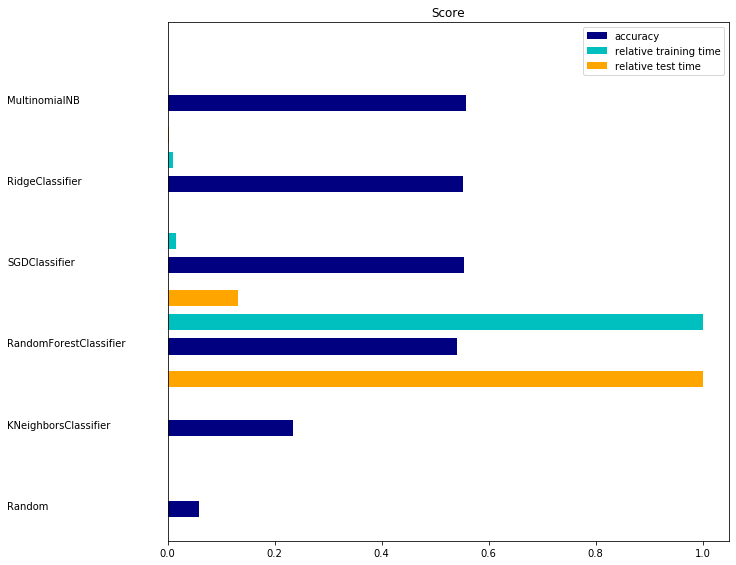

In [15]:
indices = np.arange(len(results))

results = [[x[i] for x in results] for i in range(4)]

clf_names, score, training_time, test_time = results
training_time = np.array(training_time) / np.max(training_time)
test_time = np.array(test_time) / np.max(test_time)

plt.figure(figsize=(12, 8))
plt.title("Score")
plt.barh(indices, score, .2, label="accuracy", color='navy')
plt.barh(indices + .3, training_time, .2, label="relative training time",
         color='c')
plt.barh(indices + .6, test_time, .2, label="relative test time", color='orange')
plt.yticks(())
plt.legend(loc='best')
plt.subplots_adjust(left=.25)
plt.subplots_adjust(top=.95)
plt.subplots_adjust(bottom=.05)

for i, c in zip(indices, clf_names):
    plt.text(-.3, i, c)

plt.show()